# Free Lunch (there is such a thing!)
Working with NYC DOE to develope a method to optimize school lunch and breakfast reimbursements from the federal and state government.

###Overview
The Community Eligibility Provision (CEP) is program aimed at streamlining reimbursement claims. It requires that participating schools provide universal breakfast and lunch service, where all meals are served at no cost to the students.

###Reimbursement Rules:
Schools get reimbursed at either the "free" rate or the "paid" rate for each meal. (Other programs have an additional "reduced" rate, but that does not apply here). The fraction of meals that get reimbursed at the "free" rate is determined by the group the school is enrolled under. This fraction we will call the $threshold$. The rest of the meals get reimbursed at the "paid" rate. 

At a minimum, the USDA covers the paid rate,$r_{lunch/breakfast,paid}$, for all meals.This includes total number of breakfasts for all schools $\sum_{s}B_s$, and total number of lunches for all schools $\sum_{s}L_s$. 

This $base$ reimbursement is independant of the groupings: 
$base = r_{lunch,paid} \sum_{s}L_s + r_{breakfast,paid} \sum_{s}B_s $.

The total Reimbursement, $R$, is

$\begin{align}
R = \sum_{s} Min(1,threshold_s) [\Delta r_{lunch} L_s  + \Delta r_{breakfast} B_s] + base
\end{align}$

> where 
> $\begin{align}
\Delta r_{breakfast} &= r_{breakfast,free} - r_{breakfast,paid} \\
\Delta r_{lunch} &= r_{lunch,free} - r_{lunch,paid}
\end{align}$

> and the $threshold_s$ for each school, $s$, is determined it's group, $g$. It is the fraction of "identified students" $I_s$ for all schools in the group $g$ to the total number of "enrolled students" $N_s$ for all schools in the group, multiplied by a constant. This constant is set by the USDA at 1.6 but may change in subsequent years. $I_s$ and $N_s$ are based on enrollment in the previous school year. "Identified students" are those deemed categorically eligible for free meals, primarily due to receiving some sort of public assistance benefit.

> $\begin{align}
threshold_s =\frac{ \sum_{s\in g} I_s} {\sum_{s\in g} N_s } * 1.6   
\end{align}$

Before the school year begins, the groups are set and reported to the state.

Reimbursements happen on a monthly basis after the school year begins.


###Grouping Rules
* All groups have to meet the minimum threshold: $threshold_{min} = 40\% * 1.6 = 64\%$
* There can be at most 9 (?) groups

###Objective
Find the optimum groupings to maximize reimbursement, $R$.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

In [2]:
#constants

multiplier = 1.6

# combined Federal and NY State meal reimbursement rates
freeLunch = 3.2999
paidLunch = 0.4399
freeBreakfast = 2.1413
paidBreakfast = 0.2923

deltaLunchRate = freeLunch - paidLunch
deltaBreakfastRate = freeBreakfast - paidBreakfast 

t_min = 0.40 * multiplier

## Test data from DOE

In [3]:
# reading in data
doe = pd.read_excel('Test Data for CEP Grouping.xlsx',sheetname="School Data",header=2)
doe.rename(columns={'Identified Student Count':'Identified'},inplace=True)
print doe.shape
doe.head()

(1487, 5)


,School,Enrollment,Identified,Breakfast,Lunch
0,1019,268.0,114.0,13744.040323,32119.415317
1,1025,188.0,121.0,2660.633468,8954.467200
2,1034,348.0,262.0,18359.910484,39773.741129
3,1060,679.0,293.0,7340.885081,19996.654634
4,1061,291.0,99.0,4320.555242,25602.863216


###Data Dictionary
* School -  the school unique id
* Enrollment - the total number of students enrolled at the school
* Identified - the number of 'identified' students enrolled at the school. (should be less than Enrollment)
* Breakfast - the projected annual number of breakfasts served at the school.
* Lunch - the projected annual number of lunches served at the school


The Breakfast and Lunch columns are both pojected values by DOE. The actual numbers are not available until after the school year begins, after the groupings are already set.


###Question on meal projections
There are 180 days in a school year. Yet there are 21 schools serving more than 200 lunches in a school year and 5 serving more than 200 breakfasts. Perhaps this includes summer? 

There are about 260 weekdays per year. 4 schools have more than 260 lunches per student.  

In [4]:
# 34 schools have 0 enrollment. Not sure what this means. For now I'll drop them.
doe[doe.Enrollment==0].shape

(34, 5)

In [5]:
days=180
df = doe[doe.Enrollment>0]
lunchPerStudent = (df.Lunch/df.Enrollment)
print 'number of schools with more than '+str(days)+' lunches per student:',lunchPerStudent[lunchPerStudent>days].shape[0]
print lunchPerStudent.describe()

bfPerStudent = (df.Breakfast/df.Enrollment)
print 'number of schools with more than '+str(days)+' breakfasts per student:', bfPerStudent[bfPerStudent>days].shape[0]
print bfPerStudent.describe()

number of schools with more than 180 lunches per student: 34
count    1453.000000
mean       94.770633
std        45.258483
min         0.000000
25%        59.845391
50%        95.510703
75%       127.086483
max       348.600914
dtype: float64
number of schools with more than 180 breakfasts per student: 8
count    1453.000000
mean       46.492607
std        39.671440
min         0.000000
25%        16.926299
50%        36.138271
75%        62.974926
max       259.759480
dtype: float64


In [6]:
# meals per student per year
df = doe[doe.Enrollment>0]
print df.Lunch.sum()/df.Enrollment.sum(),df.Breakfast.sum()/df.Enrollment.sum()

91.2768119568 40.0380279164


In [7]:
print 'total number of students:', doe.Enrollment.sum()

total number of students: 726513.966002


### CEP dataframe

In [8]:
# assume only schools with >0 enrollment can be part of cep program.
cep = doe[doe.Enrollment>0].copy()
cep.shape

(1453, 5)

In [9]:
# the number of identified students should always be less then the number of enrolled students,
# checking this out to make sure
(cep.Identified/cep.Enrollment).describe()

count    1453.000000
mean        0.475177
std         0.209910
min         0.000000
25%         0.320847
50%         0.490946
75%         0.643182
max         0.910165
dtype: float64

In [10]:
# define a few more columns that are useful.
# 'meal' is the max reimbursement of meals per year for each school.
# 'mealPerStudent' is the max per student.
# 'baseThreshold' is the threshold of the school if it is not grouped.
# 'group' will hold the integer name of the group the school belongs too. initally set a single group.

cep['meal'] = deltaLunchRate*cep['Lunch'] + deltaBreakfastRate*cep['Breakfast']
cep['paidMeal'] = paidLunch*cep['Lunch'] + paidBreakfast*cep['Breakfast']
cep['mealPerStudent'] = cep['meal']/cep['Enrollment']
cep['baseThreshold'] = cep['Identified']/cep['Enrollment']*multiplier
cep['group'] = 0

cep.head()

,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold,group
0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597,0
1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787,0
2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598,0
3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427,0
4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330,0


## To group or Not to group?

####Constraints
The minimum threshold constraint of 64% has to be met. So any schools less than that, have to be grouped with schools with larger base thresholds. Any schools with base thresholds greater than 100% should be grouped with schools with smaller base thresholds in order to increase their effectiveness (since there is a cut off over 100%. Any group with a threshold over 100% can be viewed as an inefficiency.

####Grouping with the threshold limits
For schools within these limits (64%-100%), there still may be a benefit to grouping depending on their projected meal count. The overall idea is to get those schools with the largest meal counts to increase their thresholds. 

Let's look at the difference in reimbursements between grouping two schools together and keeping them separate:

$\begin{align}
\Delta R_{12} \equiv R_{12} - (R_1 + R_2)
\end{align}$

$R_{12}$ is the reimbursement when school 1 and 2 are grouped together. $R_1+R_2$ is the reimbursement when they are separate. Assume the thresholds for 1 and 2 are both between the limits (64%-100%). 

After some algebra:

$\begin{align}
\Delta R_{12} =  (threshold_2 - threshold_1)(m_1 - m_2)\frac{N_1 N_2}{N_1 + N_2}
\end{align}$

> where $m_i$ is the potential meal cost increase per student (mealPerStudent):

> $\begin{align}
\qquad m_i = \frac{\Delta r_{lunch} L_i + \Delta r_{breakfast} B_i}{N_i} \textrm{   for   } i=1,2
\end{align}$


* If $\Delta R_{12} = 0$ then the reimbursement is the same whether or not you group the schools. This happens when the thresholds for the two schools are equal or the mealsPerStudent are equal.


* If $\Delta R_{12} > 0$ then the schools should be combined. This happens in 2 cases: 

$\begin{align}
\qquad (threshold_1 < threshold_2) &\textrm{ AND } (m_1 > m_2) \\
&\textrm{ OR} \\
\qquad (threshold_1 > threshold_2) &\textrm{ AND } (m_1 < m_2)
\end{align}$

## Plotting out what this looks like with the DOE data

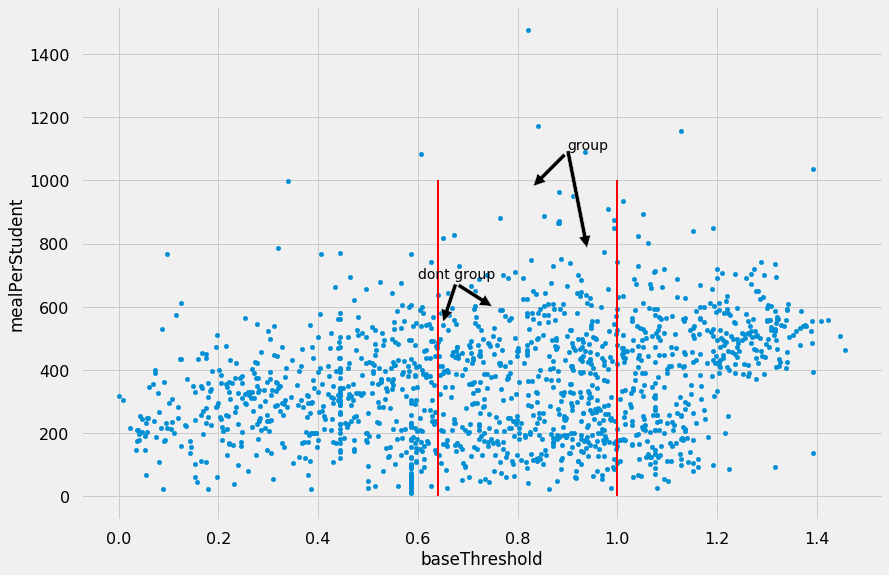

In [11]:
ax=cep.plot.scatter(x='baseThreshold',y='mealPerStudent')

ax.annotate('group', xy=(.83, 980), xytext=(.9, 1100),
            arrowprops=dict(facecolor='black', shrink=0.02))
ax.annotate('', xy=(.94, 780), xytext=(.9, 1100),
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.annotate('dont group', xy=(.65, 550), xytext=(.6, 690),
            arrowprops=dict(facecolor='black', shrink=0.02))
ax.annotate('', xy=(.75, 600), xytext=(.68, 670),
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.plot([t_min,t_min],[0,1000],'r-',lw=2)
plt.plot([1,1],[0,1000],'r-',lw=2)

(53, 10)


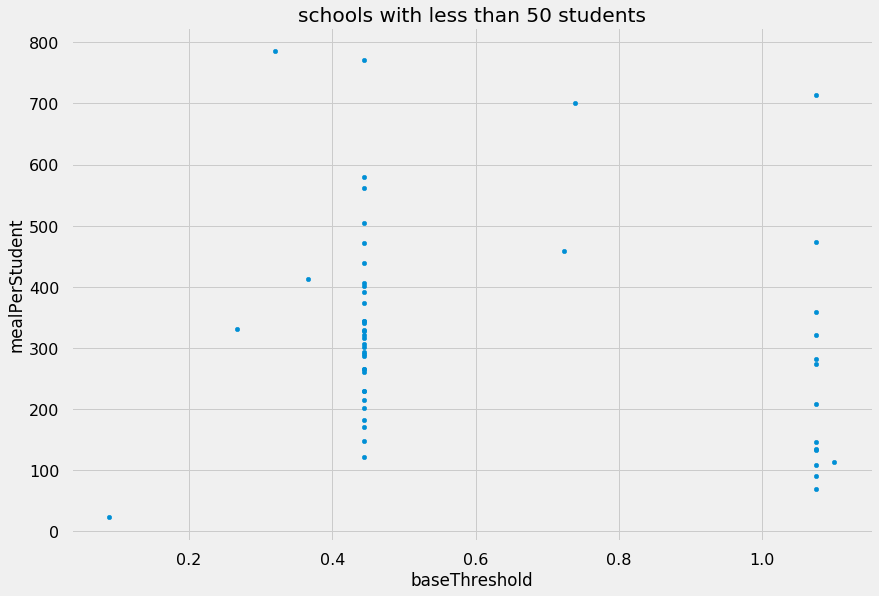

In [12]:
print cep[cep.Enrollment<50].shape
cep[cep.Enrollment<50].plot.scatter(x='baseThreshold',y='mealPerStudent',
                                    title='schools with less than 50 students')

For schools with less students, the meal projections are probably not very accurate.

## Vectorized Code:

So far I've only rewritten and tested the simulated annealing process

All my functions are prefaced with *SR_*

In [13]:
def SR_calcReimburse(cep):
    group_cep = cep.groupby('group')
    df = pd.DataFrame(index= group_cep.indices)

    df['threshold'] =  (group_cep['Identified'].sum()  / group_cep['Enrollment'].sum()) * multiplier
    df['meal']      =  group_cep['meal'].sum()
    df['paidMeal']  =  group_cep['paidMeal'].sum()



    df['applied_threshold'] = df['threshold']
    df.loc[df['applied_threshold']  > 1, 'applied_threshold'] = 1
    df.loc[df['applied_threshold']  < t_min,'applied_threshold'] = 0

    df['reimbursed'] = df['applied_threshold'] * df['meal']

    df.loc[df['applied_threshold']  == 0,'reimbursed'] = -df['paidMeal']

    return df.reimbursed.sum()

def SR_detailsReimburse(cep):
    group_cep = cep.groupby('group')
    df = pd.DataFrame(index= group_cep.indices)

    df['threshold'] =  (group_cep['Identified'].sum()  / group_cep['Enrollment'].sum()) * multiplier
    df['meal']      =  group_cep['meal'].sum()
    df['paidMeal']  =  group_cep['paidMeal'].sum()



    df['applied_threshold'] = df['threshold']
    df.loc[df['applied_threshold']  > 1, 'applied_threshold'] = 1
    df.loc[df['applied_threshold']  < t_min,'applied_threshold'] = 0

    df['reimbursed'] = df['applied_threshold'] * df['meal']

    df.loc[df['applied_threshold']  == 0,'reimbursed'] = -df['paidMeal']

    return df


def SR_simulated_annealing(cep, seed, ngroups = 10):
    startTime = time.time()

    # start by grouping schools randomly
    np.random.seed(seed)
    cep['group'] = pd.Series(np.random.randint(0,ngroups,size=cep.shape[0]))

    # store the results in sa
    sa=[]
    sa.append(SR_calcReimburse(cep))

    # mc loop
    for T in np.arange(1,0,-.01):
        for i in range(100):
            
            group_idx = cep.group.copy()
            
            # choose a random school and move it to a new random group
            cep.iloc[np.random.randint(0,group_idx.shape[0]), cep.columns.get_loc('group')] = np.random.randint(0,ngroups)
                                                                                   
            # calculate the reimbursement
            temp = SR_calcReimburse(cep)
                                                                                        
            #keep move if reimbursement increases
            if (temp > sa[-1]):
                sa.append(temp)
            #maybe keep move if reimbursement decreases, depending on how much
            elif (np.random.uniform() < np.exp((temp-sa[-1])/T)):
                sa.append(temp)
            else:
                cep.group = group_idx # don't keep the change
                
    print sa[-1]
    print 'time in h', (time.time() - startTime)/60.0/60.0
    return sa , cep
            





In [16]:
cepSR = cep.copy().reset_index(drop = True)

sa, cep_optimal = SR_simulated_annealing(cepSR, seed = 26)

186320151.885
time in h 0.0177671644423


In [19]:
import multiprocessing as mp

pool = mp.Pool(processes=4)

seed = [26, 45, 123, 9]
ngroups = [1, 10, 100, 1000]
results = [pool.apply_async(SR_simulated_annealing, args = (cepSR,s,20)) for s in seed]

results = [p.get() for p in results]


187527875.83
time in h 0.375762682226
187307572.287
time in h 0.376081315544
187398323.334
time in h 0.377237733006
189508796.525
time in h 0.378720792267


## Original Method: Calculating Reimbursements based on school groupings

In [20]:
# all meals in the CEP program are reimbursed at a minimum at the paid rate
baseReimburse = paidLunch*cep.Lunch.sum() + paidBreakfast*cep.Breakfast.sum()

# reimbursements over the base, this is the part that's dependant on groupings
def calcReimburse(df,result):
    ''' 
    calculates the reimbur
    sements per school. 
    Each row in df is a school.
    Updates df 'threshold' and 'reimburse' columns.
    Results stored in results list
    ''' 
    # calc threshold.(can be >1)
    for i in set(df.group):
        df.loc[df.group == i,'threshold'] = groupThreshold(df[df.group==i])
    
    # based on threshold, calculate reimbursement for each row
    # if threshold is less than t_min, set reimburse to 0
    df['reimburse'] = df[['threshold','meal','paidMeal']].apply(reimburse,axis=1)

    # store 'results' as a list of lists. 
    #     The inner lists 0th item saves info about the groupings,
    #     the 1st item is the number of groups
    #     the 2nd item is the reimbusement (above base reimbursement)
    #     the 3rd item is whether or not the threshold has been met for the goups
    #if df['threshold'].min() >= t_min:
    #    result.append([df[['group','threshold','meal']].copy(),len(set(df.group)),
    #                    df.reimburse.sum(),'threshold met'])
    #else:
    #    result.append([df[['group','threshold','meal']].copy(),len(set(df.group)),
    #                   df.reimburse.sum(),'threshold not met'])
    result.append(df.reimburse.sum())
    return result

def reimburse(x):
    threshold,meal,paidMeal = x[0],x[1],x[2]
    if threshold<t_min:
        return -paidMeal
    elif threshold>=1:
        return meal
    else:
        return meal*threshold
    
def groupThreshold(df):
    '''given a dataframe df, assuming all rows are in the same 'group', this calculates the
    'threshold' for the full group'''
    return (df['Identified'].sum()) / float(df['Enrollment'].sum())*multiplier

def groupReimburse(df):
    '''given a dataframe df, assuming all rows are in the same 'group', this calculates the
    reimbursements for the full group.
    includes a hard limit to meet minimum threshold'''
    td = groupThreshold(df)
    ml = df['meal'].sum()
    pml = df['paidMeal'].sum()
    return reimburse([td,ml,pml])

def deltaReimburse(df,group1,group2):
    '''difference in reimbursement with combining groups vs separate'''
    df12 = df[(df['group'] == group1)|(df['group'] == group2)].copy()
    r12 = groupReimburse(df12)

    df1 = df[df['group'] == group1].copy()
    r1 = groupReimburse(df1)
     
    df2 = df[df['group'] == group2].copy()
    r2 = groupReimburse(df2)

    return r12 - r1 - r2


simulated annealing

In [25]:


def simulated_annealing(cep, seed, ngroups = 10):
    cep.reset_index(inplace = True)  
    startTime = time.time()

    # start by grouping schools randomly
    np.random.seed(seed)
    cep['group'] = pd.Series(np.random.randint(0,ngroups,size=cep.shape[0]))

    # store the results in sa
    sa=[]
    sa = calcReimburse(cep,sa)

    # mc loop
    for T in np.arange(1,0,-.01):
        for i in range(100):
            temp=[]
            df=cep.copy()
            # choose a random school and move it to a new random group
            df.loc[np.random.randint(0,cep.shape[0]),'group'] = np.random.randint(0,ngroups)
            # calculate the reimbursement
            temp=calcReimburse(df,temp)
            #keep move if reimbursement increases
            if (temp[-1] > sa[-1]):
                cep.group = df.group
                sa.append(temp[-1])
            #maybe keep move if reimbursement decreases, depending on how much
            elif (np.random.uniform() < np.exp((temp[-1]-sa[-1])/T)):
                cep.group = df.group
                sa.append(temp[-1])


    temp = calcReimburse(cep,temp)
    print sa[-1]
    print 'time in h', (time.time() - startTime)/60.0/60.0
    return sa, cep



In [1]:
### comparison

cep_DP = cep.copy.reset_index()

sa_DP , cep_optimal_DP = simulated_annealing(cep,seed=26)

NameError: name 'cep' is not defined